In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

class TimeEncoding(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2)*scale, requires_grad=False)
        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    
    
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.dense(x)[..., None, None]
    
    
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(
            TimeEncoding(embed_dim=embed_dim), 
            nn.Linear(embed_dim, embed_dim)
        ) # time embedding
        
        # UNet encoder
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        
        # UNet decoder
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        
        # switch activation
        self.act = lambda x: x * torch.sigmoid(x)
        
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        self.marginal_prob_std = marginal_prob_std
        
    def forward(self, x, t):
        embed = self.act(self.embed(t))
        
        # encode
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        
        # decode
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))
        
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

/home/bliao/miniconda3/envs/prune/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [3]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    
    score = score_model(perturbed_x, random_t)
    
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z) ** 2, dim=(1,2,3)))
    return loss

In [4]:
from copy import deepcopy

class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)
            
    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))
        
    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)
        
    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)
        

In [5]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50
batch_size = 32
lr = 1e-4

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.tqdm(range(n_epochs))

ema = EMA(score_model)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0.
    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(score_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    print("Average ScoreMatching Loss: {:5f}".format(avg_loss / num_items))
    torch.save(score_model.state_dict(), "ckpt.pth")

/home/bliao/miniconda3/envs/prune/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|                                                               | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_59481/1764053612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  2%|█                                                      | 1/50 [00:26<21:35, 26.44s/it]

Average ScoreMatching Loss: 697.911057


  4%|██▏                                                    | 2/50 [00:50<20:11, 25.25s/it]

Average ScoreMatching Loss: 101.882520


  6%|███▎                                                   | 3/50 [01:15<19:38, 25.08s/it]

Average ScoreMatching Loss: 54.275092


  8%|████▍                                                  | 4/50 [01:40<19:09, 24.98s/it]

Average ScoreMatching Loss: 38.972932


 10%|█████▌                                                 | 5/50 [02:05<18:44, 25.00s/it]

Average ScoreMatching Loss: 32.405056


 12%|██████▌                                                | 6/50 [02:30<18:16, 24.92s/it]

Average ScoreMatching Loss: 28.459775


 14%|███████▋                                               | 7/50 [02:54<17:45, 24.78s/it]

Average ScoreMatching Loss: 26.275807


 16%|████████▊                                              | 8/50 [03:19<17:22, 24.81s/it]

Average ScoreMatching Loss: 24.695130


 18%|█████████▉                                             | 9/50 [03:43<16:48, 24.61s/it]

Average ScoreMatching Loss: 23.838059


 20%|██████████▊                                           | 10/50 [04:08<16:21, 24.53s/it]

Average ScoreMatching Loss: 22.516307


 22%|███████████▉                                          | 11/50 [04:33<16:03, 24.70s/it]

Average ScoreMatching Loss: 21.778200


 24%|████████████▉                                         | 12/50 [04:58<15:42, 24.80s/it]

Average ScoreMatching Loss: 21.309169


 26%|██████████████                                        | 13/50 [05:23<15:17, 24.79s/it]

Average ScoreMatching Loss: 21.027546


 28%|███████████████                                       | 14/50 [05:47<14:53, 24.81s/it]

Average ScoreMatching Loss: 20.770738


 30%|████████████████▏                                     | 15/50 [06:12<14:25, 24.72s/it]

Average ScoreMatching Loss: 20.098822


 32%|█████████████████▎                                    | 16/50 [06:37<13:59, 24.70s/it]

Average ScoreMatching Loss: 20.026866


 34%|██████████████████▎                                   | 17/50 [07:01<13:34, 24.67s/it]

Average ScoreMatching Loss: 19.721056


 36%|███████████████████▍                                  | 18/50 [07:26<13:08, 24.64s/it]

Average ScoreMatching Loss: 19.502713


 38%|████████████████████▌                                 | 19/50 [07:50<12:43, 24.63s/it]

Average ScoreMatching Loss: 19.370473


 40%|█████████████████████▌                                | 20/50 [08:15<12:16, 24.56s/it]

Average ScoreMatching Loss: 19.116794


 42%|██████████████████████▋                               | 21/50 [08:39<11:52, 24.57s/it]

Average ScoreMatching Loss: 18.950565


 44%|███████████████████████▊                              | 22/50 [09:04<11:26, 24.51s/it]

Average ScoreMatching Loss: 18.832744


 46%|████████████████████████▊                             | 23/50 [09:29<11:04, 24.60s/it]

Average ScoreMatching Loss: 18.825491


 48%|█████████████████████████▉                            | 24/50 [09:53<10:37, 24.51s/it]

Average ScoreMatching Loss: 18.726077


 50%|███████████████████████████                           | 25/50 [10:17<10:09, 24.37s/it]

Average ScoreMatching Loss: 18.502403


 52%|████████████████████████████                          | 26/50 [10:42<09:48, 24.51s/it]

Average ScoreMatching Loss: 18.670595


 54%|█████████████████████████████▏                        | 27/50 [11:06<09:25, 24.57s/it]

Average ScoreMatching Loss: 18.239438


 56%|██████████████████████████████▏                       | 28/50 [11:31<09:01, 24.60s/it]

Average ScoreMatching Loss: 18.267964


 58%|███████████████████████████████▎                      | 29/50 [11:56<08:37, 24.66s/it]

Average ScoreMatching Loss: 17.913231


 60%|████████████████████████████████▍                     | 30/50 [12:21<08:13, 24.69s/it]

Average ScoreMatching Loss: 18.138579


 62%|█████████████████████████████████▍                    | 31/50 [12:45<07:46, 24.57s/it]

Average ScoreMatching Loss: 18.031699


 64%|██████████████████████████████████▌                   | 32/50 [13:09<07:20, 24.47s/it]

Average ScoreMatching Loss: 17.998697


 66%|███████████████████████████████████▋                  | 33/50 [13:34<06:56, 24.50s/it]

Average ScoreMatching Loss: 17.791834


 68%|████████████████████████████████████▋                 | 34/50 [13:58<06:32, 24.54s/it]

Average ScoreMatching Loss: 17.522767


 70%|█████████████████████████████████████▊                | 35/50 [14:23<06:08, 24.59s/it]

Average ScoreMatching Loss: 17.591003


 72%|██████████████████████████████████████▉               | 36/50 [14:48<05:44, 24.64s/it]

Average ScoreMatching Loss: 17.475714


 74%|███████████████████████████████████████▉              | 37/50 [15:12<05:18, 24.49s/it]

Average ScoreMatching Loss: 17.486260


 76%|█████████████████████████████████████████             | 38/50 [15:37<04:54, 24.55s/it]

Average ScoreMatching Loss: 17.548403


 78%|██████████████████████████████████████████            | 39/50 [16:01<04:29, 24.51s/it]

Average ScoreMatching Loss: 17.363014


 80%|███████████████████████████████████████████▏          | 40/50 [16:26<04:05, 24.56s/it]

Average ScoreMatching Loss: 17.325367


 82%|████████████████████████████████████████████▎         | 41/50 [16:51<03:41, 24.61s/it]

Average ScoreMatching Loss: 17.270136


 84%|█████████████████████████████████████████████▎        | 42/50 [17:15<03:17, 24.64s/it]

Average ScoreMatching Loss: 17.276490


 86%|██████████████████████████████████████████████▍       | 43/50 [17:40<02:52, 24.63s/it]

Average ScoreMatching Loss: 17.317975


 88%|███████████████████████████████████████████████▌      | 44/50 [18:04<02:26, 24.50s/it]

Average ScoreMatching Loss: 17.278193


 90%|████████████████████████████████████████████████▌     | 45/50 [18:29<02:02, 24.51s/it]

Average ScoreMatching Loss: 17.105406


 92%|█████████████████████████████████████████████████▋    | 46/50 [18:53<01:37, 24.50s/it]

Average ScoreMatching Loss: 17.115847


 94%|██████████████████████████████████████████████████▊   | 47/50 [19:18<01:13, 24.64s/it]

Average ScoreMatching Loss: 17.103855


 96%|███████████████████████████████████████████████████▊  | 48/50 [19:43<00:49, 24.64s/it]

Average ScoreMatching Loss: 16.969132


 98%|████████████████████████████████████████████████████▉ | 49/50 [20:07<00:24, 24.58s/it]

Average ScoreMatching Loss: 17.075774


100%|██████████████████████████████████████████████████████| 50/50 [20:31<00:00, 24.64s/it]

Average ScoreMatching Loss: 17.067063


In [22]:
num_steps = 500
def euler_sampler(
        score_model,
        marginal_prob_std,
        diffusion_coeff,
        batch_size=64,
        num_steps=num_steps,
        device="cuda",
        eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            
    return mean_x

In [18]:
signal_to_noise_ratio = 0.16
num_steps = 500
def pc_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              num_steps=num_steps,
              snr = signal_to_noise_ratio,
              device="cuda",
              eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
            print(f"{langevin_step_size=}")
            
            for _ in range(10):
                x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
                grad = score_model(x, batch_time_step)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
                print(f"{langevin_step_size=}")
            
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g ** 2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
            
        return x_mean

In [19]:
from scipy import integrate

error_tolerance = 1e-5
def ode_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               atol=error_tolerance,
               rtol=error_tolerance,
               device="cuda",
               z=None,
               eps=1e-3):

    t = torch.ones(batch_size, device=device)
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
        
    shape = init_x.shape
    
    def score_eval_wrapper(sample, time_steps):
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0],))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
        
    def ode_func(t, x):
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return - 0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method="RK45")
    print(f"Number of function evaluation: {res.nfev}")
    
    return torch.tensor(res.y[:, -1], device=device).reshape(shape)

/tmp/ipykernel_59481/1764053612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                              | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_59481/1764053612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
  1%|▍                                                     | 4/500 [00:00<00:15, 31.07it/s]

langevin_step_size=tensor(4.6991, device='cuda:0')
langevin_step_size=tensor(4.6972, device='cuda:0')
langevin_step_size=tensor(4.6777, device='cuda:0')
langevin_step_size=tensor(4.6787, device='cuda:0')
langevin_step_size=tensor(4.6955, device='cuda:0')
langevin_step_size=tensor(4.6994, device='cuda:0')
langevin_step_size=tensor(4.7077, device='cuda:0')
langevin_step_size=tensor(4.7060, device='cuda:0')
langevin_step_size=tensor(4.7170, device='cuda:0')
langevin_step_size=tensor(4.7176, device='cuda:0')
langevin_step_size=tensor(4.7412, device='cuda:0')
langevin_step_size=tensor(4.8539, device='cuda:0')
langevin_step_size=tensor(4.8428, device='cuda:0')
langevin_step_size=tensor(4.8296, device='cuda:0')
langevin_step_size=tensor(4.8214, device='cuda:0')
langevin_step_size=tensor(4.8006, device='cuda:0')
langevin_step_size=tensor(4.8238, device='cuda:0')
langevin_step_size=tensor(4.8100, device='cuda:0')
langevin_step_size=tensor(4.8037, device='cuda:0')
langevin_step_size=tensor(4.785

  2%|█▎                                                   | 12/500 [00:00<00:16, 30.33it/s]

langevin_step_size=tensor(4.4695, device='cuda:0')
langevin_step_size=tensor(4.4941, device='cuda:0')
langevin_step_size=tensor(4.4615, device='cuda:0')
langevin_step_size=tensor(4.4573, device='cuda:0')
langevin_step_size=tensor(4.4521, device='cuda:0')
langevin_step_size=tensor(4.4734, device='cuda:0')
langevin_step_size=tensor(4.4712, device='cuda:0')
langevin_step_size=tensor(4.4711, device='cuda:0')
langevin_step_size=tensor(4.4197, device='cuda:0')
langevin_step_size=tensor(4.4040, device='cuda:0')
langevin_step_size=tensor(4.4233, device='cuda:0')
langevin_step_size=tensor(4.4585, device='cuda:0')
langevin_step_size=tensor(4.4760, device='cuda:0')
langevin_step_size=tensor(4.4510, device='cuda:0')
langevin_step_size=tensor(4.4282, device='cuda:0')
langevin_step_size=tensor(4.4314, device='cuda:0')
langevin_step_size=tensor(4.4232, device='cuda:0')
langevin_step_size=tensor(4.4127, device='cuda:0')
langevin_step_size=tensor(4.4082, device='cuda:0')
langevin_step_size=tensor(4.361

  3%|█▋                                                   | 16/500 [00:00<00:16, 30.05it/s]

langevin_step_size=tensor(4.1624, device='cuda:0')
langevin_step_size=tensor(4.1550, device='cuda:0')
langevin_step_size=tensor(4.1495, device='cuda:0')
langevin_step_size=tensor(4.1542, device='cuda:0')
langevin_step_size=tensor(4.1428, device='cuda:0')
langevin_step_size=tensor(4.1475, device='cuda:0')
langevin_step_size=tensor(4.1329, device='cuda:0')
langevin_step_size=tensor(4.0752, device='cuda:0')
langevin_step_size=tensor(4.0983, device='cuda:0')
langevin_step_size=tensor(4.0890, device='cuda:0')
langevin_step_size=tensor(4.0963, device='cuda:0')
langevin_step_size=tensor(4.0777, device='cuda:0')
langevin_step_size=tensor(4.1072, device='cuda:0')
langevin_step_size=tensor(4.0879, device='cuda:0')
langevin_step_size=tensor(4.0955, device='cuda:0')
langevin_step_size=tensor(4.1082, device='cuda:0')
langevin_step_size=tensor(4.1137, device='cuda:0')
langevin_step_size=tensor(4.1174, device='cuda:0')
langevin_step_size=tensor(4.0614, device='cuda:0')
langevin_step_size=tensor(4.051

  5%|██▍                                                  | 23/500 [00:00<00:15, 29.87it/s]

langevin_step_size=tensor(3.8570, device='cuda:0')
langevin_step_size=tensor(3.8482, device='cuda:0')
langevin_step_size=tensor(3.8674, device='cuda:0')
langevin_step_size=tensor(3.8690, device='cuda:0')
langevin_step_size=tensor(3.8723, device='cuda:0')
langevin_step_size=tensor(3.8733, device='cuda:0')
langevin_step_size=tensor(3.8195, device='cuda:0')
langevin_step_size=tensor(3.8221, device='cuda:0')
langevin_step_size=tensor(3.8252, device='cuda:0')
langevin_step_size=tensor(3.8023, device='cuda:0')
langevin_step_size=tensor(3.8001, device='cuda:0')
langevin_step_size=tensor(3.7989, device='cuda:0')
langevin_step_size=tensor(3.8149, device='cuda:0')
langevin_step_size=tensor(3.8025, device='cuda:0')
langevin_step_size=tensor(3.7962, device='cuda:0')
langevin_step_size=tensor(3.7893, device='cuda:0')
langevin_step_size=tensor(3.7852, device='cuda:0')
langevin_step_size=tensor(3.7346, device='cuda:0')
langevin_step_size=tensor(3.7234, device='cuda:0')
langevin_step_size=tensor(3.735

  6%|███                                                  | 29/500 [00:00<00:15, 29.78it/s]

langevin_step_size=tensor(3.5635, device='cuda:0')
langevin_step_size=tensor(3.5691, device='cuda:0')
langevin_step_size=tensor(3.5812, device='cuda:0')
langevin_step_size=tensor(3.5908, device='cuda:0')
langevin_step_size=tensor(3.5916, device='cuda:0')
langevin_step_size=tensor(3.5949, device='cuda:0')
langevin_step_size=tensor(3.5524, device='cuda:0')
langevin_step_size=tensor(3.5601, device='cuda:0')
langevin_step_size=tensor(3.5531, device='cuda:0')
langevin_step_size=tensor(3.5752, device='cuda:0')
langevin_step_size=tensor(3.5639, device='cuda:0')
langevin_step_size=tensor(3.5656, device='cuda:0')
langevin_step_size=tensor(3.5704, device='cuda:0')
langevin_step_size=tensor(3.5493, device='cuda:0')
langevin_step_size=tensor(3.5500, device='cuda:0')
langevin_step_size=tensor(3.5742, device='cuda:0')
langevin_step_size=tensor(3.5691, device='cuda:0')
langevin_step_size=tensor(3.5322, device='cuda:0')
langevin_step_size=tensor(3.5285, device='cuda:0')
langevin_step_size=tensor(3.546

  7%|███▋                                                 | 35/500 [00:01<00:15, 29.58it/s]

langevin_step_size=tensor(3.2912, device='cuda:0')
langevin_step_size=tensor(3.2792, device='cuda:0')
langevin_step_size=tensor(3.2767, device='cuda:0')
langevin_step_size=tensor(3.2811, device='cuda:0')
langevin_step_size=tensor(3.2913, device='cuda:0')
langevin_step_size=tensor(3.2937, device='cuda:0')
langevin_step_size=tensor(3.2529, device='cuda:0')
langevin_step_size=tensor(3.2551, device='cuda:0')
langevin_step_size=tensor(3.2587, device='cuda:0')
langevin_step_size=tensor(3.2619, device='cuda:0')
langevin_step_size=tensor(3.2786, device='cuda:0')
langevin_step_size=tensor(3.2756, device='cuda:0')
langevin_step_size=tensor(3.2748, device='cuda:0')
langevin_step_size=tensor(3.2628, device='cuda:0')
langevin_step_size=tensor(3.2658, device='cuda:0')
langevin_step_size=tensor(3.2785, device='cuda:0')
langevin_step_size=tensor(3.2843, device='cuda:0')
langevin_step_size=tensor(3.2402, device='cuda:0')
langevin_step_size=tensor(3.2339, device='cuda:0')
langevin_step_size=tensor(3.229

  8%|████▎                                                | 41/500 [00:01<00:15, 29.45it/s]

langevin_step_size=tensor(3.0570, device='cuda:0')
langevin_step_size=tensor(3.0436, device='cuda:0')
langevin_step_size=tensor(3.0482, device='cuda:0')
langevin_step_size=tensor(3.0662, device='cuda:0')
langevin_step_size=tensor(3.0728, device='cuda:0')
langevin_step_size=tensor(3.0563, device='cuda:0')
langevin_step_size=tensor(3.0580, device='cuda:0')
langevin_step_size=tensor(3.0217, device='cuda:0')
langevin_step_size=tensor(3.0280, device='cuda:0')
langevin_step_size=tensor(3.0306, device='cuda:0')
langevin_step_size=tensor(3.0318, device='cuda:0')
langevin_step_size=tensor(3.0212, device='cuda:0')
langevin_step_size=tensor(3.0268, device='cuda:0')
langevin_step_size=tensor(3.0319, device='cuda:0')
langevin_step_size=tensor(3.0341, device='cuda:0')
langevin_step_size=tensor(3.0334, device='cuda:0')
langevin_step_size=tensor(3.0298, device='cuda:0')
langevin_step_size=tensor(3.0295, device='cuda:0')
langevin_step_size=tensor(2.9986, device='cuda:0')
langevin_step_size=tensor(2.997

  9%|████▉                                                | 47/500 [00:01<00:15, 29.23it/s]

langevin_step_size=tensor(2.8344, device='cuda:0')
langevin_step_size=tensor(2.8440, device='cuda:0')
langevin_step_size=tensor(2.8535, device='cuda:0')
langevin_step_size=tensor(2.8477, device='cuda:0')
langevin_step_size=tensor(2.8393, device='cuda:0')
langevin_step_size=tensor(2.8362, device='cuda:0')
langevin_step_size=tensor(2.8173, device='cuda:0')
langevin_step_size=tensor(2.8260, device='cuda:0')
langevin_step_size=tensor(2.7809, device='cuda:0')
langevin_step_size=tensor(2.7876, device='cuda:0')
langevin_step_size=tensor(2.7905, device='cuda:0')
langevin_step_size=tensor(2.7979, device='cuda:0')
langevin_step_size=tensor(2.8058, device='cuda:0')
langevin_step_size=tensor(2.8072, device='cuda:0')
langevin_step_size=tensor(2.8059, device='cuda:0')
langevin_step_size=tensor(2.7954, device='cuda:0')
langevin_step_size=tensor(2.7855, device='cuda:0')
langevin_step_size=tensor(2.7779, device='cuda:0')
langevin_step_size=tensor(2.7754, device='cuda:0')
langevin_step_size=tensor(2.731

 11%|█████▌                                               | 53/500 [00:01<00:15, 29.31it/s]

langevin_step_size=tensor(2.6082, device='cuda:0')
langevin_step_size=tensor(2.6087, device='cuda:0')
langevin_step_size=tensor(2.6169, device='cuda:0')
langevin_step_size=tensor(2.6212, device='cuda:0')
langevin_step_size=tensor(2.6192, device='cuda:0')
langevin_step_size=tensor(2.6217, device='cuda:0')
langevin_step_size=tensor(2.6251, device='cuda:0')
langevin_step_size=tensor(2.6107, device='cuda:0')
langevin_step_size=tensor(2.6184, device='cuda:0')
langevin_step_size=tensor(2.5844, device='cuda:0')
langevin_step_size=tensor(2.5854, device='cuda:0')
langevin_step_size=tensor(2.5822, device='cuda:0')
langevin_step_size=tensor(2.5728, device='cuda:0')
langevin_step_size=tensor(2.5747, device='cuda:0')
langevin_step_size=tensor(2.5772, device='cuda:0')
langevin_step_size=tensor(2.5752, device='cuda:0')
langevin_step_size=tensor(2.5840, device='cuda:0')
langevin_step_size=tensor(2.5909, device='cuda:0')
langevin_step_size=tensor(2.5789, device='cuda:0')
langevin_step_size=tensor(2.588

 12%|██████▎                                              | 59/500 [00:01<00:15, 29.17it/s]

langevin_step_size=tensor(2.3989, device='cuda:0')
langevin_step_size=tensor(2.3902, device='cuda:0')
langevin_step_size=tensor(2.3889, device='cuda:0')
langevin_step_size=tensor(2.3999, device='cuda:0')
langevin_step_size=tensor(2.4019, device='cuda:0')
langevin_step_size=tensor(2.3975, device='cuda:0')
langevin_step_size=tensor(2.3983, device='cuda:0')
langevin_step_size=tensor(2.3927, device='cuda:0')
langevin_step_size=tensor(2.4012, device='cuda:0')
langevin_step_size=tensor(2.4010, device='cuda:0')
langevin_step_size=tensor(2.3751, device='cuda:0')
langevin_step_size=tensor(2.3710, device='cuda:0')
langevin_step_size=tensor(2.3675, device='cuda:0')
langevin_step_size=tensor(2.3793, device='cuda:0')
langevin_step_size=tensor(2.3839, device='cuda:0')
langevin_step_size=tensor(2.3909, device='cuda:0')
langevin_step_size=tensor(2.3899, device='cuda:0')
langevin_step_size=tensor(2.3754, device='cuda:0')
langevin_step_size=tensor(2.3752, device='cuda:0')
langevin_step_size=tensor(2.372

 13%|██████▉                                              | 65/500 [00:02<00:14, 29.34it/s]

langevin_step_size=tensor(2.2548, device='cuda:0')
langevin_step_size=tensor(2.2506, device='cuda:0')
langevin_step_size=tensor(2.2498, device='cuda:0')
langevin_step_size=tensor(2.2462, device='cuda:0')
langevin_step_size=tensor(2.2528, device='cuda:0')
langevin_step_size=tensor(2.2552, device='cuda:0')
langevin_step_size=tensor(2.2530, device='cuda:0')
langevin_step_size=tensor(2.2568, device='cuda:0')
langevin_step_size=tensor(2.2547, device='cuda:0')
langevin_step_size=tensor(2.2579, device='cuda:0')
langevin_step_size=tensor(2.2556, device='cuda:0')
langevin_step_size=tensor(2.2256, device='cuda:0')
langevin_step_size=tensor(2.2290, device='cuda:0')
langevin_step_size=tensor(2.2289, device='cuda:0')
langevin_step_size=tensor(2.2304, device='cuda:0')
langevin_step_size=tensor(2.2332, device='cuda:0')
langevin_step_size=tensor(2.2375, device='cuda:0')
langevin_step_size=tensor(2.2476, device='cuda:0')
langevin_step_size=tensor(2.2532, device='cuda:0')
langevin_step_size=tensor(2.250

 14%|███████▌                                             | 71/500 [00:02<00:14, 29.22it/s]

langevin_step_size=tensor(2.0952, device='cuda:0')
langevin_step_size=tensor(2.0977, device='cuda:0')
langevin_step_size=tensor(2.1041, device='cuda:0')
langevin_step_size=tensor(2.0915, device='cuda:0')
langevin_step_size=tensor(2.0841, device='cuda:0')
langevin_step_size=tensor(2.0868, device='cuda:0')
langevin_step_size=tensor(2.0836, device='cuda:0')
langevin_step_size=tensor(2.0816, device='cuda:0')
langevin_step_size=tensor(2.0844, device='cuda:0')
langevin_step_size=tensor(2.0875, device='cuda:0')
langevin_step_size=tensor(2.0801, device='cuda:0')
langevin_step_size=tensor(2.0523, device='cuda:0')
langevin_step_size=tensor(2.0483, device='cuda:0')
langevin_step_size=tensor(2.0476, device='cuda:0')
langevin_step_size=tensor(2.0480, device='cuda:0')
langevin_step_size=tensor(2.0343, device='cuda:0')
langevin_step_size=tensor(2.0338, device='cuda:0')
langevin_step_size=tensor(2.0366, device='cuda:0')
langevin_step_size=tensor(2.0377, device='cuda:0')
langevin_step_size=tensor(2.038

 15%|████████▏                                            | 77/500 [00:02<00:14, 29.36it/s]

langevin_step_size=tensor(1.9079, device='cuda:0')
langevin_step_size=tensor(1.9012, device='cuda:0')
langevin_step_size=tensor(1.9033, device='cuda:0')
langevin_step_size=tensor(1.9102, device='cuda:0')
langevin_step_size=tensor(1.9038, device='cuda:0')
langevin_step_size=tensor(1.8975, device='cuda:0')
langevin_step_size=tensor(1.8998, device='cuda:0')
langevin_step_size=tensor(1.9045, device='cuda:0')
langevin_step_size=tensor(1.9060, device='cuda:0')
langevin_step_size=tensor(1.9024, device='cuda:0')
langevin_step_size=tensor(1.9078, device='cuda:0')
langevin_step_size=tensor(1.8891, device='cuda:0')
langevin_step_size=tensor(1.8907, device='cuda:0')
langevin_step_size=tensor(1.8902, device='cuda:0')
langevin_step_size=tensor(1.8941, device='cuda:0')
langevin_step_size=tensor(1.8900, device='cuda:0')
langevin_step_size=tensor(1.8900, device='cuda:0')
langevin_step_size=tensor(1.8887, device='cuda:0')
langevin_step_size=tensor(1.8808, device='cuda:0')
langevin_step_size=tensor(1.890

 17%|████████▊                                            | 83/500 [00:02<00:14, 29.49it/s]

langevin_step_size=tensor(1.7555, device='cuda:0')
langevin_step_size=tensor(1.7573, device='cuda:0')
langevin_step_size=tensor(1.7519, device='cuda:0')
langevin_step_size=tensor(1.7516, device='cuda:0')
langevin_step_size=tensor(1.7569, device='cuda:0')
langevin_step_size=tensor(1.7614, device='cuda:0')
langevin_step_size=tensor(1.7750, device='cuda:0')
langevin_step_size=tensor(1.7766, device='cuda:0')
langevin_step_size=tensor(1.7779, device='cuda:0')
langevin_step_size=tensor(1.7748, device='cuda:0')
langevin_step_size=tensor(1.7825, device='cuda:0')
langevin_step_size=tensor(1.7604, device='cuda:0')
langevin_step_size=tensor(1.7644, device='cuda:0')
langevin_step_size=tensor(1.7700, device='cuda:0')
langevin_step_size=tensor(1.7676, device='cuda:0')
langevin_step_size=tensor(1.7673, device='cuda:0')
langevin_step_size=tensor(1.7706, device='cuda:0')
langevin_step_size=tensor(1.7677, device='cuda:0')
langevin_step_size=tensor(1.7605, device='cuda:0')
langevin_step_size=tensor(1.753

 18%|█████████▍                                           | 89/500 [00:03<00:14, 29.34it/s]

langevin_step_size=tensor(1.6458, device='cuda:0')
langevin_step_size=tensor(1.6444, device='cuda:0')
langevin_step_size=tensor(1.6382, device='cuda:0')
langevin_step_size=tensor(1.6346, device='cuda:0')
langevin_step_size=tensor(1.6263, device='cuda:0')
langevin_step_size=tensor(1.6274, device='cuda:0')
langevin_step_size=tensor(1.6286, device='cuda:0')
langevin_step_size=tensor(1.6302, device='cuda:0')
langevin_step_size=tensor(1.6279, device='cuda:0')
langevin_step_size=tensor(1.6304, device='cuda:0')
langevin_step_size=tensor(1.6133, device='cuda:0')
langevin_step_size=tensor(1.6090, device='cuda:0')
langevin_step_size=tensor(1.6106, device='cuda:0')
langevin_step_size=tensor(1.6134, device='cuda:0')
langevin_step_size=tensor(1.6182, device='cuda:0')
langevin_step_size=tensor(1.6100, device='cuda:0')
langevin_step_size=tensor(1.6119, device='cuda:0')
langevin_step_size=tensor(1.6178, device='cuda:0')
langevin_step_size=tensor(1.6183, device='cuda:0')
langevin_step_size=tensor(1.626

 19%|██████████                                           | 95/500 [00:03<00:13, 29.40it/s]

langevin_step_size=tensor(1.5189, device='cuda:0')
langevin_step_size=tensor(1.5187, device='cuda:0')
langevin_step_size=tensor(1.5158, device='cuda:0')
langevin_step_size=tensor(1.5164, device='cuda:0')
langevin_step_size=tensor(1.5148, device='cuda:0')
langevin_step_size=tensor(1.5146, device='cuda:0')
langevin_step_size=tensor(1.5169, device='cuda:0')
langevin_step_size=tensor(1.5229, device='cuda:0')
langevin_step_size=tensor(1.5268, device='cuda:0')
langevin_step_size=tensor(1.5262, device='cuda:0')
langevin_step_size=tensor(1.5191, device='cuda:0')
langevin_step_size=tensor(1.5013, device='cuda:0')
langevin_step_size=tensor(1.4997, device='cuda:0')
langevin_step_size=tensor(1.5062, device='cuda:0')
langevin_step_size=tensor(1.5036, device='cuda:0')
langevin_step_size=tensor(1.5022, device='cuda:0')
langevin_step_size=tensor(1.5103, device='cuda:0')
langevin_step_size=tensor(1.5042, device='cuda:0')
langevin_step_size=tensor(1.5104, device='cuda:0')
langevin_step_size=tensor(1.513

 20%|██████████▌                                         | 101/500 [00:03<00:13, 29.41it/s]

langevin_step_size=tensor(1.4154, device='cuda:0')
langevin_step_size=tensor(1.4108, device='cuda:0')
langevin_step_size=tensor(1.4047, device='cuda:0')
langevin_step_size=tensor(1.4062, device='cuda:0')
langevin_step_size=tensor(1.4078, device='cuda:0')
langevin_step_size=tensor(1.4047, device='cuda:0')
langevin_step_size=tensor(1.4040, device='cuda:0')
langevin_step_size=tensor(1.4027, device='cuda:0')
langevin_step_size=tensor(1.4033, device='cuda:0')
langevin_step_size=tensor(1.4016, device='cuda:0')
langevin_step_size=tensor(1.4037, device='cuda:0')
langevin_step_size=tensor(1.3883, device='cuda:0')
langevin_step_size=tensor(1.3882, device='cuda:0')
langevin_step_size=tensor(1.3862, device='cuda:0')
langevin_step_size=tensor(1.3876, device='cuda:0')
langevin_step_size=tensor(1.3911, device='cuda:0')
langevin_step_size=tensor(1.3926, device='cuda:0')
langevin_step_size=tensor(1.3913, device='cuda:0')
langevin_step_size=tensor(1.3962, device='cuda:0')
langevin_step_size=tensor(1.396

 22%|███████████▏                                        | 108/500 [00:03<00:13, 29.77it/s]

langevin_step_size=tensor(1.3035, device='cuda:0')
langevin_step_size=tensor(1.3028, device='cuda:0')
langevin_step_size=tensor(1.3033, device='cuda:0')
langevin_step_size=tensor(1.3021, device='cuda:0')
langevin_step_size=tensor(1.3063, device='cuda:0')
langevin_step_size=tensor(1.3108, device='cuda:0')
langevin_step_size=tensor(1.3133, device='cuda:0')
langevin_step_size=tensor(1.3133, device='cuda:0')
langevin_step_size=tensor(1.3192, device='cuda:0')
langevin_step_size=tensor(1.3176, device='cuda:0')
langevin_step_size=tensor(1.3231, device='cuda:0')
langevin_step_size=tensor(1.3084, device='cuda:0')
langevin_step_size=tensor(1.3046, device='cuda:0')
langevin_step_size=tensor(1.3022, device='cuda:0')
langevin_step_size=tensor(1.3016, device='cuda:0')
langevin_step_size=tensor(1.3061, device='cuda:0')
langevin_step_size=tensor(1.3057, device='cuda:0')
langevin_step_size=tensor(1.3050, device='cuda:0')
langevin_step_size=tensor(1.3055, device='cuda:0')
langevin_step_size=tensor(1.309

 23%|███████████▊                                        | 114/500 [00:03<00:13, 29.56it/s]

langevin_step_size=tensor(1.2091, device='cuda:0')
langevin_step_size=tensor(1.2076, device='cuda:0')
langevin_step_size=tensor(1.2086, device='cuda:0')
langevin_step_size=tensor(1.2106, device='cuda:0')
langevin_step_size=tensor(1.2137, device='cuda:0')
langevin_step_size=tensor(1.2140, device='cuda:0')
langevin_step_size=tensor(1.2153, device='cuda:0')
langevin_step_size=tensor(1.2128, device='cuda:0')
langevin_step_size=tensor(1.2143, device='cuda:0')
langevin_step_size=tensor(1.2111, device='cuda:0')
langevin_step_size=tensor(1.1940, device='cuda:0')
langevin_step_size=tensor(1.1950, device='cuda:0')
langevin_step_size=tensor(1.1944, device='cuda:0')
langevin_step_size=tensor(1.1974, device='cuda:0')
langevin_step_size=tensor(1.1992, device='cuda:0')
langevin_step_size=tensor(1.1987, device='cuda:0')
langevin_step_size=tensor(1.1963, device='cuda:0')
langevin_step_size=tensor(1.2002, device='cuda:0')
langevin_step_size=tensor(1.2015, device='cuda:0')
langevin_step_size=tensor(1.201

 24%|████████████▍                                       | 120/500 [00:04<00:12, 29.47it/s]

langevin_step_size=tensor(1.1240, device='cuda:0')
langevin_step_size=tensor(1.1202, device='cuda:0')
langevin_step_size=tensor(1.1184, device='cuda:0')
langevin_step_size=tensor(1.1116, device='cuda:0')
langevin_step_size=tensor(1.1138, device='cuda:0')
langevin_step_size=tensor(1.1177, device='cuda:0')
langevin_step_size=tensor(1.1142, device='cuda:0')
langevin_step_size=tensor(1.1176, device='cuda:0')
langevin_step_size=tensor(1.1181, device='cuda:0')
langevin_step_size=tensor(1.1153, device='cuda:0')
langevin_step_size=tensor(1.1153, device='cuda:0')
langevin_step_size=tensor(1.1022, device='cuda:0')
langevin_step_size=tensor(1.0995, device='cuda:0')
langevin_step_size=tensor(1.0997, device='cuda:0')
langevin_step_size=tensor(1.1009, device='cuda:0')
langevin_step_size=tensor(1.0955, device='cuda:0')
langevin_step_size=tensor(1.0988, device='cuda:0')
langevin_step_size=tensor(1.0989, device='cuda:0')
langevin_step_size=tensor(1.0936, device='cuda:0')
langevin_step_size=tensor(1.091

 25%|████████████▊                                       | 123/500 [00:04<00:12, 29.38it/s]

langevin_step_size=tensor(1.0335, device='cuda:0')
langevin_step_size=tensor(1.0353, device='cuda:0')
langevin_step_size=tensor(1.0305, device='cuda:0')
langevin_step_size=tensor(1.0345, device='cuda:0')
langevin_step_size=tensor(1.0345, device='cuda:0')
langevin_step_size=tensor(1.0363, device='cuda:0')
langevin_step_size=tensor(1.0349, device='cuda:0')
langevin_step_size=tensor(1.0374, device='cuda:0')
langevin_step_size=tensor(1.0387, device='cuda:0')
langevin_step_size=tensor(1.0433, device='cuda:0')
langevin_step_size=tensor(1.0394, device='cuda:0')
langevin_step_size=tensor(1.0274, device='cuda:0')
langevin_step_size=tensor(1.0275, device='cuda:0')
langevin_step_size=tensor(1.0213, device='cuda:0')
langevin_step_size=tensor(1.0225, device='cuda:0')
langevin_step_size=tensor(1.0244, device='cuda:0')
langevin_step_size=tensor(1.0233, device='cuda:0')
langevin_step_size=tensor(1.0244, device='cuda:0')
langevin_step_size=tensor(1.0252, device='cuda:0')
langevin_step_size=tensor(1.023

 26%|█████████████▌                                      | 130/500 [00:04<00:12, 29.46it/s]

langevin_step_size=tensor(0.9541, device='cuda:0')
langevin_step_size=tensor(0.9572, device='cuda:0')
langevin_step_size=tensor(0.9531, device='cuda:0')
langevin_step_size=tensor(0.9500, device='cuda:0')
langevin_step_size=tensor(0.9514, device='cuda:0')
langevin_step_size=tensor(0.9522, device='cuda:0')
langevin_step_size=tensor(0.9520, device='cuda:0')
langevin_step_size=tensor(0.9492, device='cuda:0')
langevin_step_size=tensor(0.9484, device='cuda:0')
langevin_step_size=tensor(0.9508, device='cuda:0')
langevin_step_size=tensor(0.9397, device='cuda:0')
langevin_step_size=tensor(0.9422, device='cuda:0')
langevin_step_size=tensor(0.9474, device='cuda:0')
langevin_step_size=tensor(0.9489, device='cuda:0')
langevin_step_size=tensor(0.9532, device='cuda:0')
langevin_step_size=tensor(0.9501, device='cuda:0')
langevin_step_size=tensor(0.9530, device='cuda:0')
langevin_step_size=tensor(0.9532, device='cuda:0')
langevin_step_size=tensor(0.9515, device='cuda:0')
langevin_step_size=tensor(0.951

 27%|██████████████▏                                     | 136/500 [00:04<00:12, 29.38it/s]

langevin_step_size=tensor(0.8843, device='cuda:0')
langevin_step_size=tensor(0.8855, device='cuda:0')
langevin_step_size=tensor(0.8859, device='cuda:0')
langevin_step_size=tensor(0.8915, device='cuda:0')
langevin_step_size=tensor(0.8909, device='cuda:0')
langevin_step_size=tensor(0.8867, device='cuda:0')
langevin_step_size=tensor(0.8881, device='cuda:0')
langevin_step_size=tensor(0.8873, device='cuda:0')
langevin_step_size=tensor(0.8868, device='cuda:0')
langevin_step_size=tensor(0.8868, device='cuda:0')
langevin_step_size=tensor(0.8859, device='cuda:0')
langevin_step_size=tensor(0.8748, device='cuda:0')
langevin_step_size=tensor(0.8745, device='cuda:0')
langevin_step_size=tensor(0.8753, device='cuda:0')
langevin_step_size=tensor(0.8778, device='cuda:0')
langevin_step_size=tensor(0.8744, device='cuda:0')
langevin_step_size=tensor(0.8768, device='cuda:0')
langevin_step_size=tensor(0.8754, device='cuda:0')
langevin_step_size=tensor(0.8746, device='cuda:0')
langevin_step_size=tensor(0.878

 28%|██████████████▊                                     | 142/500 [00:04<00:12, 29.42it/s]

langevin_step_size=tensor(0.8190, device='cuda:0')
langevin_step_size=tensor(0.8223, device='cuda:0')
langevin_step_size=tensor(0.8227, device='cuda:0')
langevin_step_size=tensor(0.8218, device='cuda:0')
langevin_step_size=tensor(0.8238, device='cuda:0')
langevin_step_size=tensor(0.8238, device='cuda:0')
langevin_step_size=tensor(0.8240, device='cuda:0')
langevin_step_size=tensor(0.8233, device='cuda:0')
langevin_step_size=tensor(0.8201, device='cuda:0')
langevin_step_size=tensor(0.8193, device='cuda:0')
langevin_step_size=tensor(0.8201, device='cuda:0')
langevin_step_size=tensor(0.8083, device='cuda:0')
langevin_step_size=tensor(0.8080, device='cuda:0')
langevin_step_size=tensor(0.8055, device='cuda:0')
langevin_step_size=tensor(0.8045, device='cuda:0')
langevin_step_size=tensor(0.8049, device='cuda:0')
langevin_step_size=tensor(0.8058, device='cuda:0')
langevin_step_size=tensor(0.8074, device='cuda:0')
langevin_step_size=tensor(0.8070, device='cuda:0')
langevin_step_size=tensor(0.807

 30%|███████████████▍                                    | 148/500 [00:05<00:12, 29.22it/s]

langevin_step_size=tensor(0.7540, device='cuda:0')
langevin_step_size=tensor(0.7538, device='cuda:0')
langevin_step_size=tensor(0.7555, device='cuda:0')
langevin_step_size=tensor(0.7582, device='cuda:0')
langevin_step_size=tensor(0.7595, device='cuda:0')
langevin_step_size=tensor(0.7595, device='cuda:0')
langevin_step_size=tensor(0.7591, device='cuda:0')
langevin_step_size=tensor(0.7600, device='cuda:0')
langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7580, device='cuda:0')
langevin_step_size=tensor(0.7585, device='cuda:0')
langevin_step_size=tensor(0.7483, device='cuda:0')
langevin_step_size=tensor(0.7459, device='cuda:0')
langevin_step_size=tensor(0.7474, device='cuda:0')
langevin_step_size=tensor(0.7490, device='cuda:0')
langevin_step_size=tensor(0.7497, device='cuda:0')
langevin_step_size=tensor(0.7487, device='cuda:0')
langevin_step_size=tensor(0.7461, device='cuda:0')
langevin_step_size=tensor(0.7472, device='cuda:0')
langevin_step_size=tensor(0.748

 31%|████████████████                                    | 154/500 [00:05<00:11, 29.37it/s]

langevin_step_size=tensor(0.7091, device='cuda:0')
langevin_step_size=tensor(0.7091, device='cuda:0')
langevin_step_size=tensor(0.7067, device='cuda:0')
langevin_step_size=tensor(0.7088, device='cuda:0')
langevin_step_size=tensor(0.7079, device='cuda:0')
langevin_step_size=tensor(0.7066, device='cuda:0')
langevin_step_size=tensor(0.7075, device='cuda:0')
langevin_step_size=tensor(0.7080, device='cuda:0')
langevin_step_size=tensor(0.7075, device='cuda:0')
langevin_step_size=tensor(0.7078, device='cuda:0')
langevin_step_size=tensor(0.7089, device='cuda:0')
langevin_step_size=tensor(0.7009, device='cuda:0')
langevin_step_size=tensor(0.6966, device='cuda:0')
langevin_step_size=tensor(0.6939, device='cuda:0')
langevin_step_size=tensor(0.6913, device='cuda:0')
langevin_step_size=tensor(0.6919, device='cuda:0')
langevin_step_size=tensor(0.6942, device='cuda:0')
langevin_step_size=tensor(0.6925, device='cuda:0')
langevin_step_size=tensor(0.6892, device='cuda:0')
langevin_step_size=tensor(0.689

 32%|████████████████▋                                   | 160/500 [00:05<00:11, 29.35it/s]

langevin_step_size=tensor(0.6520, device='cuda:0')
langevin_step_size=tensor(0.6497, device='cuda:0')
langevin_step_size=tensor(0.6527, device='cuda:0')
langevin_step_size=tensor(0.6537, device='cuda:0')
langevin_step_size=tensor(0.6537, device='cuda:0')
langevin_step_size=tensor(0.6539, device='cuda:0')
langevin_step_size=tensor(0.6533, device='cuda:0')
langevin_step_size=tensor(0.6539, device='cuda:0')
langevin_step_size=tensor(0.6533, device='cuda:0')
langevin_step_size=tensor(0.6524, device='cuda:0')
langevin_step_size=tensor(0.6476, device='cuda:0')
langevin_step_size=tensor(0.6375, device='cuda:0')
langevin_step_size=tensor(0.6356, device='cuda:0')
langevin_step_size=tensor(0.6350, device='cuda:0')
langevin_step_size=tensor(0.6338, device='cuda:0')
langevin_step_size=tensor(0.6336, device='cuda:0')
langevin_step_size=tensor(0.6321, device='cuda:0')
langevin_step_size=tensor(0.6338, device='cuda:0')
langevin_step_size=tensor(0.6338, device='cuda:0')
langevin_step_size=tensor(0.634

 33%|█████████████████▎                                  | 166/500 [00:05<00:11, 29.35it/s]

langevin_step_size=tensor(0.6019, device='cuda:0')
langevin_step_size=tensor(0.6026, device='cuda:0')
langevin_step_size=tensor(0.6031, device='cuda:0')
langevin_step_size=tensor(0.6009, device='cuda:0')
langevin_step_size=tensor(0.6031, device='cuda:0')
langevin_step_size=tensor(0.6002, device='cuda:0')
langevin_step_size=tensor(0.6009, device='cuda:0')
langevin_step_size=tensor(0.6025, device='cuda:0')
langevin_step_size=tensor(0.6045, device='cuda:0')
langevin_step_size=tensor(0.6028, device='cuda:0')
langevin_step_size=tensor(0.6041, device='cuda:0')
langevin_step_size=tensor(0.5976, device='cuda:0')
langevin_step_size=tensor(0.5970, device='cuda:0')
langevin_step_size=tensor(0.5973, device='cuda:0')
langevin_step_size=tensor(0.5942, device='cuda:0')
langevin_step_size=tensor(0.5955, device='cuda:0')
langevin_step_size=tensor(0.5937, device='cuda:0')
langevin_step_size=tensor(0.5979, device='cuda:0')
langevin_step_size=tensor(0.5959, device='cuda:0')
langevin_step_size=tensor(0.593

 34%|█████████████████▉                                  | 172/500 [00:05<00:11, 29.34it/s]

langevin_step_size=tensor(0.5552, device='cuda:0')
langevin_step_size=tensor(0.5519, device='cuda:0')
langevin_step_size=tensor(0.5524, device='cuda:0')
langevin_step_size=tensor(0.5483, device='cuda:0')
langevin_step_size=tensor(0.5490, device='cuda:0')
langevin_step_size=tensor(0.5480, device='cuda:0')
langevin_step_size=tensor(0.5473, device='cuda:0')
langevin_step_size=tensor(0.5490, device='cuda:0')
langevin_step_size=tensor(0.5502, device='cuda:0')
langevin_step_size=tensor(0.5483, device='cuda:0')
langevin_step_size=tensor(0.5503, device='cuda:0')
langevin_step_size=tensor(0.5428, device='cuda:0')
langevin_step_size=tensor(0.5437, device='cuda:0')
langevin_step_size=tensor(0.5482, device='cuda:0')
langevin_step_size=tensor(0.5484, device='cuda:0')
langevin_step_size=tensor(0.5493, device='cuda:0')
langevin_step_size=tensor(0.5490, device='cuda:0')
langevin_step_size=tensor(0.5474, device='cuda:0')
langevin_step_size=tensor(0.5481, device='cuda:0')
langevin_step_size=tensor(0.548

 36%|██████████████████▌                                 | 178/500 [00:06<00:10, 29.35it/s]

langevin_step_size=tensor(0.5156, device='cuda:0')
langevin_step_size=tensor(0.5168, device='cuda:0')
langevin_step_size=tensor(0.5150, device='cuda:0')
langevin_step_size=tensor(0.5133, device='cuda:0')
langevin_step_size=tensor(0.5135, device='cuda:0')
langevin_step_size=tensor(0.5113, device='cuda:0')
langevin_step_size=tensor(0.5113, device='cuda:0')
langevin_step_size=tensor(0.5110, device='cuda:0')
langevin_step_size=tensor(0.5116, device='cuda:0')
langevin_step_size=tensor(0.5129, device='cuda:0')
langevin_step_size=tensor(0.5135, device='cuda:0')
langevin_step_size=tensor(0.5088, device='cuda:0')
langevin_step_size=tensor(0.5078, device='cuda:0')
langevin_step_size=tensor(0.5071, device='cuda:0')
langevin_step_size=tensor(0.5097, device='cuda:0')
langevin_step_size=tensor(0.5101, device='cuda:0')
langevin_step_size=tensor(0.5097, device='cuda:0')
langevin_step_size=tensor(0.5103, device='cuda:0')
langevin_step_size=tensor(0.5123, device='cuda:0')
langevin_step_size=tensor(0.513

 37%|███████████████████▏                                | 184/500 [00:06<00:10, 29.13it/s]

langevin_step_size=tensor(0.4729, device='cuda:0')
langevin_step_size=tensor(0.4729, device='cuda:0')
langevin_step_size=tensor(0.4723, device='cuda:0')
langevin_step_size=tensor(0.4706, device='cuda:0')
langevin_step_size=tensor(0.4700, device='cuda:0')
langevin_step_size=tensor(0.4694, device='cuda:0')
langevin_step_size=tensor(0.4700, device='cuda:0')
langevin_step_size=tensor(0.4714, device='cuda:0')
langevin_step_size=tensor(0.4703, device='cuda:0')
langevin_step_size=tensor(0.4719, device='cuda:0')
langevin_step_size=tensor(0.4705, device='cuda:0')
langevin_step_size=tensor(0.4632, device='cuda:0')
langevin_step_size=tensor(0.4643, device='cuda:0')
langevin_step_size=tensor(0.4634, device='cuda:0')
langevin_step_size=tensor(0.4626, device='cuda:0')
langevin_step_size=tensor(0.4615, device='cuda:0')
langevin_step_size=tensor(0.4627, device='cuda:0')
langevin_step_size=tensor(0.4632, device='cuda:0')
langevin_step_size=tensor(0.4626, device='cuda:0')
langevin_step_size=tensor(0.464

 38%|███████████████████▊                                | 190/500 [00:06<00:10, 29.19it/s]

langevin_step_size=tensor(0.4314, device='cuda:0')
langevin_step_size=tensor(0.4313, device='cuda:0')
langevin_step_size=tensor(0.4325, device='cuda:0')
langevin_step_size=tensor(0.4320, device='cuda:0')
langevin_step_size=tensor(0.4338, device='cuda:0')
langevin_step_size=tensor(0.4344, device='cuda:0')
langevin_step_size=tensor(0.4333, device='cuda:0')
langevin_step_size=tensor(0.4347, device='cuda:0')
langevin_step_size=tensor(0.4364, device='cuda:0')
langevin_step_size=tensor(0.4365, device='cuda:0')
langevin_step_size=tensor(0.4367, device='cuda:0')
langevin_step_size=tensor(0.4315, device='cuda:0')
langevin_step_size=tensor(0.4316, device='cuda:0')
langevin_step_size=tensor(0.4320, device='cuda:0')
langevin_step_size=tensor(0.4323, device='cuda:0')
langevin_step_size=tensor(0.4312, device='cuda:0')
langevin_step_size=tensor(0.4318, device='cuda:0')
langevin_step_size=tensor(0.4301, device='cuda:0')
langevin_step_size=tensor(0.4316, device='cuda:0')
langevin_step_size=tensor(0.431

 39%|████████████████████▍                               | 196/500 [00:06<00:10, 29.22it/s]

langevin_step_size=tensor(0.4093, device='cuda:0')
langevin_step_size=tensor(0.4089, device='cuda:0')
langevin_step_size=tensor(0.4079, device='cuda:0')
langevin_step_size=tensor(0.4066, device='cuda:0')
langevin_step_size=tensor(0.4059, device='cuda:0')
langevin_step_size=tensor(0.4059, device='cuda:0')
langevin_step_size=tensor(0.4061, device='cuda:0')
langevin_step_size=tensor(0.4076, device='cuda:0')
langevin_step_size=tensor(0.4074, device='cuda:0')
langevin_step_size=tensor(0.4075, device='cuda:0')
langevin_step_size=tensor(0.4084, device='cuda:0')
langevin_step_size=tensor(0.4037, device='cuda:0')
langevin_step_size=tensor(0.4036, device='cuda:0')
langevin_step_size=tensor(0.4026, device='cuda:0')
langevin_step_size=tensor(0.4017, device='cuda:0')
langevin_step_size=tensor(0.4019, device='cuda:0')
langevin_step_size=tensor(0.4016, device='cuda:0')
langevin_step_size=tensor(0.4020, device='cuda:0')
langevin_step_size=tensor(0.4007, device='cuda:0')
langevin_step_size=tensor(0.398

 40%|█████████████████████                               | 202/500 [00:06<00:10, 29.29it/s]

langevin_step_size=tensor(0.3751, device='cuda:0')
langevin_step_size=tensor(0.3758, device='cuda:0')
langevin_step_size=tensor(0.3764, device='cuda:0')
langevin_step_size=tensor(0.3762, device='cuda:0')
langevin_step_size=tensor(0.3764, device='cuda:0')
langevin_step_size=tensor(0.3770, device='cuda:0')
langevin_step_size=tensor(0.3767, device='cuda:0')
langevin_step_size=tensor(0.3764, device='cuda:0')
langevin_step_size=tensor(0.3771, device='cuda:0')
langevin_step_size=tensor(0.3785, device='cuda:0')
langevin_step_size=tensor(0.3793, device='cuda:0')
langevin_step_size=tensor(0.3742, device='cuda:0')
langevin_step_size=tensor(0.3745, device='cuda:0')
langevin_step_size=tensor(0.3742, device='cuda:0')
langevin_step_size=tensor(0.3728, device='cuda:0')
langevin_step_size=tensor(0.3724, device='cuda:0')
langevin_step_size=tensor(0.3709, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3702, device='cuda:0')
langevin_step_size=tensor(0.370

 42%|█████████████████████▋                              | 208/500 [00:07<00:09, 29.25it/s]

langevin_step_size=tensor(0.3481, device='cuda:0')
langevin_step_size=tensor(0.3470, device='cuda:0')
langevin_step_size=tensor(0.3466, device='cuda:0')
langevin_step_size=tensor(0.3454, device='cuda:0')
langevin_step_size=tensor(0.3465, device='cuda:0')
langevin_step_size=tensor(0.3484, device='cuda:0')
langevin_step_size=tensor(0.3465, device='cuda:0')
langevin_step_size=tensor(0.3471, device='cuda:0')
langevin_step_size=tensor(0.3461, device='cuda:0')
langevin_step_size=tensor(0.3466, device='cuda:0')
langevin_step_size=tensor(0.3470, device='cuda:0')
langevin_step_size=tensor(0.3431, device='cuda:0')
langevin_step_size=tensor(0.3422, device='cuda:0')
langevin_step_size=tensor(0.3405, device='cuda:0')
langevin_step_size=tensor(0.3405, device='cuda:0')
langevin_step_size=tensor(0.3407, device='cuda:0')
langevin_step_size=tensor(0.3419, device='cuda:0')
langevin_step_size=tensor(0.3414, device='cuda:0')
langevin_step_size=tensor(0.3409, device='cuda:0')
langevin_step_size=tensor(0.339

 43%|██████████████████████▎                             | 215/500 [00:07<00:09, 29.79it/s]

langevin_step_size=tensor(0.3241, device='cuda:0')
langevin_step_size=tensor(0.3239, device='cuda:0')
langevin_step_size=tensor(0.3232, device='cuda:0')
langevin_step_size=tensor(0.3228, device='cuda:0')
langevin_step_size=tensor(0.3211, device='cuda:0')
langevin_step_size=tensor(0.3214, device='cuda:0')
langevin_step_size=tensor(0.3217, device='cuda:0')
langevin_step_size=tensor(0.3215, device='cuda:0')
langevin_step_size=tensor(0.3207, device='cuda:0')
langevin_step_size=tensor(0.3212, device='cuda:0')
langevin_step_size=tensor(0.3223, device='cuda:0')
langevin_step_size=tensor(0.3175, device='cuda:0')
langevin_step_size=tensor(0.3174, device='cuda:0')
langevin_step_size=tensor(0.3179, device='cuda:0')
langevin_step_size=tensor(0.3173, device='cuda:0')
langevin_step_size=tensor(0.3178, device='cuda:0')
langevin_step_size=tensor(0.3189, device='cuda:0')
langevin_step_size=tensor(0.3181, device='cuda:0')
langevin_step_size=tensor(0.3172, device='cuda:0')
langevin_step_size=tensor(0.316

 44%|██████████████████████▊                             | 219/500 [00:07<00:09, 30.11it/s]

langevin_step_size=tensor(0.2987, device='cuda:0')
langevin_step_size=tensor(0.2988, device='cuda:0')
langevin_step_size=tensor(0.2987, device='cuda:0')
langevin_step_size=tensor(0.2993, device='cuda:0')
langevin_step_size=tensor(0.2999, device='cuda:0')
langevin_step_size=tensor(0.2990, device='cuda:0')
langevin_step_size=tensor(0.2989, device='cuda:0')
langevin_step_size=tensor(0.2999, device='cuda:0')
langevin_step_size=tensor(0.2998, device='cuda:0')
langevin_step_size=tensor(0.2959, device='cuda:0')
langevin_step_size=tensor(0.2974, device='cuda:0')
langevin_step_size=tensor(0.2981, device='cuda:0')
langevin_step_size=tensor(0.2972, device='cuda:0')
langevin_step_size=tensor(0.2961, device='cuda:0')
langevin_step_size=tensor(0.2950, device='cuda:0')
langevin_step_size=tensor(0.2947, device='cuda:0')
langevin_step_size=tensor(0.2949, device='cuda:0')
langevin_step_size=tensor(0.2921, device='cuda:0')
langevin_step_size=tensor(0.2900, device='cuda:0')
langevin_step_size=tensor(0.291

 45%|███████████████████████▌                            | 227/500 [00:07<00:08, 30.62it/s]

langevin_step_size=tensor(0.2708, device='cuda:0')
langevin_step_size=tensor(0.2712, device='cuda:0')
langevin_step_size=tensor(0.2715, device='cuda:0')
langevin_step_size=tensor(0.2721, device='cuda:0')
langevin_step_size=tensor(0.2724, device='cuda:0')
langevin_step_size=tensor(0.2684, device='cuda:0')
langevin_step_size=tensor(0.2687, device='cuda:0')
langevin_step_size=tensor(0.2696, device='cuda:0')
langevin_step_size=tensor(0.2680, device='cuda:0')
langevin_step_size=tensor(0.2681, device='cuda:0')
langevin_step_size=tensor(0.2676, device='cuda:0')
langevin_step_size=tensor(0.2690, device='cuda:0')
langevin_step_size=tensor(0.2702, device='cuda:0')
langevin_step_size=tensor(0.2703, device='cuda:0')
langevin_step_size=tensor(0.2714, device='cuda:0')
langevin_step_size=tensor(0.2716, device='cuda:0')
langevin_step_size=tensor(0.2679, device='cuda:0')
langevin_step_size=tensor(0.2677, device='cuda:0')
langevin_step_size=tensor(0.2686, device='cuda:0')
langevin_step_size=tensor(0.268

 47%|████████████████████████▍                           | 235/500 [00:07<00:08, 30.86it/s]

langevin_step_size=tensor(0.2585, device='cuda:0')
langevin_step_size=tensor(0.2586, device='cuda:0')
langevin_step_size=tensor(0.2550, device='cuda:0')
langevin_step_size=tensor(0.2543, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2532, device='cuda:0')
langevin_step_size=tensor(0.2524, device='cuda:0')
langevin_step_size=tensor(0.2523, device='cuda:0')
langevin_step_size=tensor(0.2518, device='cuda:0')
langevin_step_size=tensor(0.2506, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2500, device='cuda:0')
langevin_step_size=tensor(0.2487, device='cuda:0')
langevin_step_size=tensor(0.2456, device='cuda:0')
langevin_step_size=tensor(0.2445, device='cuda:0')
langevin_step_size=tensor(0.2446, device='cuda:0')
langevin_step_size=tensor(0.2439, device='cuda:0')
langevin_step_size=tensor(0.2447, device='cuda:0')
langevin_step_size=tensor(0.2433, device='cuda:0')
langevin_step_size=tensor(0.244

 48%|████████████████████████▊                           | 239/500 [00:08<00:08, 30.33it/s]

langevin_step_size=tensor(0.2308, device='cuda:0')
langevin_step_size=tensor(0.2320, device='cuda:0')
langevin_step_size=tensor(0.2322, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2314, device='cuda:0')
langevin_step_size=tensor(0.2320, device='cuda:0')
langevin_step_size=tensor(0.2322, device='cuda:0')
langevin_step_size=tensor(0.2327, device='cuda:0')
langevin_step_size=tensor(0.2337, device='cuda:0')
langevin_step_size=tensor(0.2333, device='cuda:0')
langevin_step_size=tensor(0.2333, device='cuda:0')
langevin_step_size=tensor(0.2306, device='cuda:0')
langevin_step_size=tensor(0.2305, device='cuda:0')
langevin_step_size=tensor(0.2301, device='cuda:0')
langevin_step_size=tensor(0.2298, device='cuda:0')
langevin_step_size=tensor(0.2293, device='cuda:0')
langevin_step_size=tensor(0.2285, device='cuda:0')
langevin_step_size=tensor(0.2286, device='cuda:0')
langevin_step_size=tensor(0.2298, device='cuda:0')
langevin_step_size=tensor(0.229

 49%|█████████████████████████▋                          | 247/500 [00:08<00:08, 29.86it/s]

langevin_step_size=tensor(0.2124, device='cuda:0')
langevin_step_size=tensor(0.2118, device='cuda:0')
langevin_step_size=tensor(0.2125, device='cuda:0')
langevin_step_size=tensor(0.2131, device='cuda:0')
langevin_step_size=tensor(0.2129, device='cuda:0')
langevin_step_size=tensor(0.2126, device='cuda:0')
langevin_step_size=tensor(0.2133, device='cuda:0')
langevin_step_size=tensor(0.2135, device='cuda:0')
langevin_step_size=tensor(0.2135, device='cuda:0')
langevin_step_size=tensor(0.2130, device='cuda:0')
langevin_step_size=tensor(0.2127, device='cuda:0')
langevin_step_size=tensor(0.2100, device='cuda:0')
langevin_step_size=tensor(0.2098, device='cuda:0')
langevin_step_size=tensor(0.2092, device='cuda:0')
langevin_step_size=tensor(0.2096, device='cuda:0')
langevin_step_size=tensor(0.2108, device='cuda:0')
langevin_step_size=tensor(0.2098, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2101, device='cuda:0')
langevin_step_size=tensor(0.209

 51%|██████████████████████████▎                         | 253/500 [00:08<00:08, 29.60it/s]

langevin_step_size=tensor(0.1957, device='cuda:0')
langevin_step_size=tensor(0.1951, device='cuda:0')
langevin_step_size=tensor(0.1954, device='cuda:0')
langevin_step_size=tensor(0.1959, device='cuda:0')
langevin_step_size=tensor(0.1958, device='cuda:0')
langevin_step_size=tensor(0.1954, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1958, device='cuda:0')
langevin_step_size=tensor(0.1955, device='cuda:0')
langevin_step_size=tensor(0.1951, device='cuda:0')
langevin_step_size=tensor(0.1946, device='cuda:0')
langevin_step_size=tensor(0.1919, device='cuda:0')
langevin_step_size=tensor(0.1922, device='cuda:0')
langevin_step_size=tensor(0.1922, device='cuda:0')
langevin_step_size=tensor(0.1924, device='cuda:0')
langevin_step_size=tensor(0.1933, device='cuda:0')
langevin_step_size=tensor(0.1929, device='cuda:0')
langevin_step_size=tensor(0.1935, device='cuda:0')
langevin_step_size=tensor(0.1922, device='cuda:0')
langevin_step_size=tensor(0.193

 51%|██████████████████████████▌                         | 256/500 [00:08<00:08, 29.24it/s]

langevin_step_size=tensor(0.1808, device='cuda:0')
langevin_step_size=tensor(0.1810, device='cuda:0')
langevin_step_size=tensor(0.1802, device='cuda:0')
langevin_step_size=tensor(0.1798, device='cuda:0')
langevin_step_size=tensor(0.1798, device='cuda:0')
langevin_step_size=tensor(0.1799, device='cuda:0')
langevin_step_size=tensor(0.1801, device='cuda:0')
langevin_step_size=tensor(0.1810, device='cuda:0')
langevin_step_size=tensor(0.1812, device='cuda:0')
langevin_step_size=tensor(0.1810, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1798, device='cuda:0')
langevin_step_size=tensor(0.1799, device='cuda:0')
langevin_step_size=tensor(0.1793, device='cuda:0')
langevin_step_size=tensor(0.1785, device='cuda:0')
langevin_step_size=tensor(0.1786, device='cuda:0')
langevin_step_size=tensor(0.1786, device='cuda:0')
langevin_step_size=tensor(0.1788, device='cuda:0')
langevin_step_size=tensor(0.179

 52%|███████████████████████████▏                        | 262/500 [00:08<00:08, 29.33it/s]

langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1674, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1675, device='cuda:0')
langevin_step_size=tensor(0.1674, device='cuda:0')
langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.1675, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1686, device='cuda:0')
langevin_step_size=tensor(0.1681, device='cuda:0')
langevin_step_size=tensor(0.1679, device='cuda:0')
langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.1652, device='cuda:0')
langevin_step_size=tensor(0.1651, device='cuda:0')
langevin_step_size=tensor(0.1647, device='cuda:0')
langevin_step_size=tensor(0.1645, device='cuda:0')
langevin_step_size=tensor(0.1643, device='cuda:0')
langevin_step_size=tensor(0.1648, device='cuda:0')
langevin_step_size=tensor(0.165

 54%|███████████████████████████▊                        | 268/500 [00:09<00:07, 29.34it/s]

langevin_step_size=tensor(0.1571, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1549, device='cuda:0')
langevin_step_size=tensor(0.1550, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1543, device='cuda:0')
langevin_step_size=tensor(0.1545, device='cuda:0')
langevin_step_size=tensor(0.1546, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1556, device='cuda:0')
langevin_step_size=tensor(0.1554, device='cuda:0')
langevin_step_size=tensor(0.1550, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1526, device='cuda:0')
langevin_step_size=tensor(0.1524, device='cuda:0')
langevin_step_size=tensor(0.1520, device='cuda:0')
langevin_step_size=tensor(0.1514, device='cuda:0')
langevin_step_size=tensor(0.1510, device='cuda:0')
langevin_step_size=tensor(0.1513, device='cuda:0')
langevin_step_size=tensor(0.151

 55%|████████████████████████████▍                       | 274/500 [00:09<00:07, 29.31it/s]

langevin_step_size=tensor(0.1426, device='cuda:0')
langevin_step_size=tensor(0.1433, device='cuda:0')
langevin_step_size=tensor(0.1416, device='cuda:0')
langevin_step_size=tensor(0.1416, device='cuda:0')
langevin_step_size=tensor(0.1415, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1411, device='cuda:0')
langevin_step_size=tensor(0.1415, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1416, device='cuda:0')
langevin_step_size=tensor(0.1417, device='cuda:0')
langevin_step_size=tensor(0.1419, device='cuda:0')
langevin_step_size=tensor(0.1422, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1407, device='cuda:0')
langevin_step_size=tensor(0.1401, device='cuda:0')
langevin_step_size=tensor(0.1404, device='cuda:0')
langevin_step_size=tensor(0.1401, device='cuda:0')
langevin_step_size=tensor(0.140

 56%|█████████████████████████████                       | 280/500 [00:09<00:07, 29.28it/s]

langevin_step_size=tensor(0.1325, device='cuda:0')
langevin_step_size=tensor(0.1327, device='cuda:0')
langevin_step_size=tensor(0.1325, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1303, device='cuda:0')
langevin_step_size=tensor(0.1304, device='cuda:0')
langevin_step_size=tensor(0.1304, device='cuda:0')
langevin_step_size=tensor(0.1307, device='cuda:0')
langevin_step_size=tensor(0.1306, device='cuda:0')
langevin_step_size=tensor(0.1315, device='cuda:0')
langevin_step_size=tensor(0.1317, device='cuda:0')
langevin_step_size=tensor(0.1322, device='cuda:0')
langevin_step_size=tensor(0.1326, device='cuda:0')
langevin_step_size=tensor(0.1324, device='cuda:0')
langevin_step_size=tensor(0.1308, device='cuda:0')
langevin_step_size=tensor(0.1308, device='cuda:0')
langevin_step_size=tensor(0.1307, device='cuda:0')
langevin_step_size=tensor(0.1304, device='cuda:0')
langevin_step_size=tensor(0.1301, device='cuda:0')
langevin_step_size=tensor(0.130

 57%|█████████████████████████████▋                      | 286/500 [00:09<00:07, 29.26it/s]

langevin_step_size=tensor(0.1223, device='cuda:0')
langevin_step_size=tensor(0.1226, device='cuda:0')
langevin_step_size=tensor(0.1223, device='cuda:0')
langevin_step_size=tensor(0.1230, device='cuda:0')
langevin_step_size=tensor(0.1217, device='cuda:0')
langevin_step_size=tensor(0.1217, device='cuda:0')
langevin_step_size=tensor(0.1218, device='cuda:0')
langevin_step_size=tensor(0.1215, device='cuda:0')
langevin_step_size=tensor(0.1219, device='cuda:0')
langevin_step_size=tensor(0.1219, device='cuda:0')
langevin_step_size=tensor(0.1220, device='cuda:0')
langevin_step_size=tensor(0.1220, device='cuda:0')
langevin_step_size=tensor(0.1222, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1223, device='cuda:0')
langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.1202, device='cuda:0')
langevin_step_size=tensor(0.1199, device='cuda:0')
langevin_step_size=tensor(0.1194, device='cuda:0')
langevin_step_size=tensor(0.119

 58%|██████████████████████████████▎                     | 292/500 [00:09<00:07, 29.03it/s]

langevin_step_size=tensor(0.1130, device='cuda:0')
langevin_step_size=tensor(0.1136, device='cuda:0')
langevin_step_size=tensor(0.1140, device='cuda:0')
langevin_step_size=tensor(0.1136, device='cuda:0')
langevin_step_size=tensor(0.1137, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1125, device='cuda:0')
langevin_step_size=tensor(0.1123, device='cuda:0')
langevin_step_size=tensor(0.1117, device='cuda:0')
langevin_step_size=tensor(0.1117, device='cuda:0')
langevin_step_size=tensor(0.1121, device='cuda:0')
langevin_step_size=tensor(0.1123, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1121, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1103, device='cuda:0')
langevin_step_size=tensor(0.110

 60%|██████████████████████████████▉                     | 298/500 [00:10<00:06, 29.02it/s]

langevin_step_size=tensor(0.1042, device='cuda:0')
langevin_step_size=tensor(0.1042, device='cuda:0')
langevin_step_size=tensor(0.1046, device='cuda:0')
langevin_step_size=tensor(0.1052, device='cuda:0')
langevin_step_size=tensor(0.1047, device='cuda:0')
langevin_step_size=tensor(0.1049, device='cuda:0')
langevin_step_size=tensor(0.1050, device='cuda:0')
langevin_step_size=tensor(0.1039, device='cuda:0')
langevin_step_size=tensor(0.1039, device='cuda:0')
langevin_step_size=tensor(0.1040, device='cuda:0')
langevin_step_size=tensor(0.1040, device='cuda:0')
langevin_step_size=tensor(0.1036, device='cuda:0')
langevin_step_size=tensor(0.1037, device='cuda:0')
langevin_step_size=tensor(0.1035, device='cuda:0')
langevin_step_size=tensor(0.1035, device='cuda:0')
langevin_step_size=tensor(0.1040, device='cuda:0')
langevin_step_size=tensor(0.1034, device='cuda:0')
langevin_step_size=tensor(0.1031, device='cuda:0')
langevin_step_size=tensor(0.1021, device='cuda:0')
langevin_step_size=tensor(0.101

 61%|███████████████████████████████▌                    | 304/500 [00:10<00:06, 29.22it/s]

langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0954, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0961, device='cuda:0')
langevin_step_size=tensor(0.0957, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0957, device='cuda:0')
langevin_step_size=tensor(0.0958, device='cuda:0')
langevin_step_size=tensor(0.0946, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0945, device='cuda:0')
langevin_step_size=tensor(0.0948, device='cuda:0')
langevin_step_size=tensor(0.0945, device='cuda:0')
langevin_step_size=tensor(0.0948, device='cuda:0')
langevin_step_size=tensor(0.0950, device='cuda:0')
langevin_step_size=tensor(0.0952, device='cuda:0')
langevin_step_size=tensor(0.0959, device='cuda:0')
langevin_step_size=tensor(0.0958, device='cuda:0')
langevin_step_size=tensor(0.0962, device='cuda:0')
langevin_step_size=tensor(0.095

 62%|████████████████████████████████▏                   | 310/500 [00:10<00:06, 29.27it/s]

langevin_step_size=tensor(0.0885, device='cuda:0')
langevin_step_size=tensor(0.0885, device='cuda:0')
langevin_step_size=tensor(0.0886, device='cuda:0')
langevin_step_size=tensor(0.0883, device='cuda:0')
langevin_step_size=tensor(0.0883, device='cuda:0')
langevin_step_size=tensor(0.0884, device='cuda:0')
langevin_step_size=tensor(0.0886, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0877, device='cuda:0')
langevin_step_size=tensor(0.0862, device='cuda:0')
langevin_step_size=tensor(0.0860, device='cuda:0')
langevin_step_size=tensor(0.0857, device='cuda:0')
langevin_step_size=tensor(0.0859, device='cuda:0')
langevin_step_size=tensor(0.0861, device='cuda:0')
langevin_step_size=tensor(0.0864, device='cuda:0')
langevin_step_size=tensor(0.0862, device='cuda:0')
langevin_step_size=tensor(0.0864, device='cuda:0')
langevin_step_size=tensor(0.0865, device='cuda:0')
langevin_step_size=tensor(0.0865, device='cuda:0')
langevin_step_size=tensor(0.086

 63%|████████████████████████████████▊                   | 316/500 [00:10<00:06, 28.99it/s]

langevin_step_size=tensor(0.0808, device='cuda:0')
langevin_step_size=tensor(0.0808, device='cuda:0')
langevin_step_size=tensor(0.0806, device='cuda:0')
langevin_step_size=tensor(0.0805, device='cuda:0')
langevin_step_size=tensor(0.0806, device='cuda:0')
langevin_step_size=tensor(0.0809, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0814, device='cuda:0')
langevin_step_size=tensor(0.0815, device='cuda:0')
langevin_step_size=tensor(0.0817, device='cuda:0')
langevin_step_size=tensor(0.0806, device='cuda:0')
langevin_step_size=tensor(0.0804, device='cuda:0')
langevin_step_size=tensor(0.0807, device='cuda:0')
langevin_step_size=tensor(0.0807, device='cuda:0')
langevin_step_size=tensor(0.0806, device='cuda:0')
langevin_step_size=tensor(0.0807, device='cuda:0')
langevin_step_size=tensor(0.0806, device='cuda:0')
langevin_step_size=tensor(0.0810, device='cuda:0')
langevin_step_size=tensor(0.0805, device='cuda:0')
langevin_step_size=tensor(0.080

 64%|█████████████████████████████████▍                  | 322/500 [00:10<00:06, 29.23it/s]

langevin_step_size=tensor(0.0756, device='cuda:0')
langevin_step_size=tensor(0.0749, device='cuda:0')
langevin_step_size=tensor(0.0745, device='cuda:0')
langevin_step_size=tensor(0.0744, device='cuda:0')
langevin_step_size=tensor(0.0742, device='cuda:0')
langevin_step_size=tensor(0.0737, device='cuda:0')
langevin_step_size=tensor(0.0738, device='cuda:0')
langevin_step_size=tensor(0.0739, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0739, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0731, device='cuda:0')
langevin_step_size=tensor(0.0733, device='cuda:0')
langevin_step_size=tensor(0.0734, device='cuda:0')
langevin_step_size=tensor(0.0736, device='cuda:0')
langevin_step_size=tensor(0.0734, device='cuda:0')
langevin_step_size=tensor(0.0737, device='cuda:0')
langevin_step_size=tensor(0.0739, device='cuda:0')
langevin_step_size=tensor(0.0736, device='cuda:0')
langevin_step_size=tensor(0.073

 66%|██████████████████████████████████                  | 328/500 [00:11<00:05, 29.26it/s]

langevin_step_size=tensor(0.0680, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0683, device='cuda:0')
langevin_step_size=tensor(0.0683, device='cuda:0')
langevin_step_size=tensor(0.0686, device='cuda:0')
langevin_step_size=tensor(0.0686, device='cuda:0')
langevin_step_size=tensor(0.0685, device='cuda:0')
langevin_step_size=tensor(0.0680, device='cuda:0')
langevin_step_size=tensor(0.0679, device='cuda:0')
langevin_step_size=tensor(0.0680, device='cuda:0')
langevin_step_size=tensor(0.0669, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.0675, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.0674, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.067

 67%|██████████████████████████████████▋                 | 334/500 [00:11<00:05, 29.22it/s]

langevin_step_size=tensor(0.0637, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0634, device='cuda:0')
langevin_step_size=tensor(0.0634, device='cuda:0')
langevin_step_size=tensor(0.0633, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0634, device='cuda:0')
langevin_step_size=tensor(0.0633, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0632, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0635, device='cuda:0')
langevin_step_size=tensor(0.0632, device='cuda:0')
langevin_step_size=tensor(0.0632, device='cuda:0')
langevin_step_size=tensor(0.0632, device='cuda:0')
langevin_step_size=tensor(0.0629, device='cuda:0')
langevin_step_size=tensor(0.0628, device='cuda:0')
langevin_step_size=tensor(0.062

 68%|███████████████████████████████████▎                | 340/500 [00:11<00:05, 29.02it/s]

langevin_step_size=tensor(0.0583, device='cuda:0')
langevin_step_size=tensor(0.0575, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0575, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0578, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0572, device='cuda:0')
langevin_step_size=tensor(0.0572, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0573, device='cuda:0')
langevin_step_size=tensor(0.0565, device='cuda:0')
langevin_step_size=tensor(0.0569, device='cuda:0')
langevin_step_size=tensor(0.0569, device='cuda:0')
langevin_step_size=tensor(0.0569, device='cuda:0')
langevin_step_size=tensor(0.0569, device='cuda:0')
langevin_step_size=tensor(0.0567, device='cuda:0')
langevin_step_size=tensor(0.0567, device='cuda:0')
langevin_step_size=tensor(0.056

 69%|███████████████████████████████████▉                | 346/500 [00:11<00:05, 29.16it/s]

langevin_step_size=tensor(0.0539, device='cuda:0')
langevin_step_size=tensor(0.0538, device='cuda:0')
langevin_step_size=tensor(0.0536, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0525, device='cuda:0')
langevin_step_size=tensor(0.0525, device='cuda:0')
langevin_step_size=tensor(0.0525, device='cuda:0')
langevin_step_size=tensor(0.0526, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0526, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0525, device='cuda:0')
langevin_step_size=tensor(0.0518, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0517, device='cuda:0')
langevin_step_size=tensor(0.0519, device='cuda:0')
langevin_step_size=tensor(0.0519, device='cuda:0')
langevin_step_size=tensor(0.051

 70%|████████████████████████████████████▌               | 352/500 [00:11<00:05, 29.24it/s]

langevin_step_size=tensor(0.0488, device='cuda:0')
langevin_step_size=tensor(0.0487, device='cuda:0')
langevin_step_size=tensor(0.0488, device='cuda:0')
langevin_step_size=tensor(0.0487, device='cuda:0')
langevin_step_size=tensor(0.0479, device='cuda:0')
langevin_step_size=tensor(0.0479, device='cuda:0')
langevin_step_size=tensor(0.0477, device='cuda:0')
langevin_step_size=tensor(0.0477, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0481, device='cuda:0')
langevin_step_size=tensor(0.0482, device='cuda:0')
langevin_step_size=tensor(0.0484, device='cuda:0')
langevin_step_size=tensor(0.0482, device='cuda:0')
langevin_step_size=tensor(0.0481, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0472, device='cuda:0')
langevin_step_size=tensor(0.0473, device='cuda:0')
langevin_step_size=tensor(0.0473, device='cuda:0')
langevin_step_size=tensor(0.0471, device='cuda:0')
langevin_step_size=tensor(0.047

 72%|█████████████████████████████████████▏              | 358/500 [00:12<00:04, 29.30it/s]

langevin_step_size=tensor(0.0447, device='cuda:0')
langevin_step_size=tensor(0.0448, device='cuda:0')
langevin_step_size=tensor(0.0448, device='cuda:0')
langevin_step_size=tensor(0.0447, device='cuda:0')
langevin_step_size=tensor(0.0447, device='cuda:0')
langevin_step_size=tensor(0.0439, device='cuda:0')
langevin_step_size=tensor(0.0439, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0435, device='cuda:0')
langevin_step_size=tensor(0.0434, device='cuda:0')
langevin_step_size=tensor(0.0435, device='cuda:0')
langevin_step_size=tensor(0.0436, device='cuda:0')
langevin_step_size=tensor(0.0434, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0436, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0429, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.043

 73%|█████████████████████████████████████▊              | 364/500 [00:12<00:04, 29.20it/s]

langevin_step_size=tensor(0.0410, device='cuda:0')
langevin_step_size=tensor(0.0411, device='cuda:0')
langevin_step_size=tensor(0.0410, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0407, device='cuda:0')
langevin_step_size=tensor(0.0409, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0402, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0402, device='cuda:0')
langevin_step_size=tensor(0.0402, device='cuda:0')
langevin_step_size=tensor(0.0401, device='cuda:0')
langevin_step_size=tensor(0.0402, device='cuda:0')
langevin_step_size=tensor(0.0401, device='cuda:0')
langevin_step_size=tensor(0.0401, device='cuda:0')
langevin_step_size=tensor(0.0402, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.039

 74%|██████████████████████████████████████▍             | 370/500 [00:12<00:04, 29.25it/s]

langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0371, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0368, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0365, device='cuda:0')
langevin_step_size=tensor(0.0366, device='cuda:0')
langevin_step_size=tensor(0.0365, device='cuda:0')
langevin_step_size=tensor(0.0365, device='cuda:0')
langevin_step_size=tensor(0.0366, device='cuda:0')
langevin_step_size=tensor(0.0365, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.036

 75%|███████████████████████████████████████             | 376/500 [00:12<00:04, 29.10it/s]

langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0340, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0340, device='cuda:0')
langevin_step_size=tensor(0.0340, device='cuda:0')
langevin_step_size=tensor(0.0340, device='cuda:0')
langevin_step_size=tensor(0.0341, device='cuda:0')
langevin_step_size=tensor(0.0341, device='cuda:0')
langevin_step_size=tensor(0.0337, device='cuda:0')
langevin_step_size=tensor(0.0336, device='cuda:0')
langevin_step_size=tensor(0.0336, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0333, device='cuda:0')
langevin_step_size=tensor(0.0333, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0333, device='cuda:0')
langevin_step_size=tensor(0.033

 76%|███████████████████████████████████████▋            | 382/500 [00:12<00:04, 29.16it/s]

langevin_step_size=tensor(0.0310, device='cuda:0')
langevin_step_size=tensor(0.0311, device='cuda:0')
langevin_step_size=tensor(0.0310, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0310, device='cuda:0')
langevin_step_size=tensor(0.0310, device='cuda:0')
langevin_step_size=tensor(0.0311, device='cuda:0')
langevin_step_size=tensor(0.0310, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0306, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.030

 78%|████████████████████████████████████████▎           | 388/500 [00:13<00:03, 29.20it/s]

langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0278, device='cuda:0')
langevin_step_size=tensor(0.0277, device='cuda:0')
langevin_step_size=tensor(0.0277, device='cuda:0')
langevin_step_size=tensor(0.0277, device='cuda:0')
langevin_step_size=tensor(0.0278, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0280, device='cuda:0')
langevin_step_size=tensor(0.0280, device='cuda:0')
langevin_step_size=tensor(0.0280, device='cuda:0')
langevin_step_size=tensor(0.0276, device='cuda:0')
langevin_step_size=tensor(0.0276, device='cuda:0')
langevin_step_size=tensor(0.0276, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0276, device='cuda:0')
langevin_step_size=tensor(0.0277, device='cuda:0')
langevin_step_size=tensor(0.027

 79%|████████████████████████████████████████▉           | 394/500 [00:13<00:03, 29.17it/s]

langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0255, device='cuda:0')
langevin_step_size=tensor(0.0255, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0255, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0254, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0250, device='cuda:0')
langevin_step_size=tensor(0.024

 80%|█████████████████████████████████████████▌          | 400/500 [00:13<00:03, 29.26it/s]

langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0224, device='cuda:0')
langevin_step_size=tensor(0.0224, device='cuda:0')
langevin_step_size=tensor(0.0223, device='cuda:0')
langevin_step_size=tensor(0.0223, device='cuda:0')
langevin_step_size=tensor(0.022

 81%|██████████████████████████████████████████▏         | 406/500 [00:13<00:03, 29.12it/s]

langevin_step_size=tensor(0.0206, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0207, device='cuda:0')
langevin_step_size=tensor(0.0208, device='cuda:0')
langevin_step_size=tensor(0.0208, device='cuda:0')
langevin_step_size=tensor(0.0208, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0204, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0204, device='cuda:0')
langevin_step_size=tensor(0.0204, device='cuda:0')
langevin_step_size=tensor(0.020

 82%|██████████████████████████████████████████▊         | 412/500 [00:14<00:03, 29.31it/s]

langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0182, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.018

 84%|███████████████████████████████████████████▍        | 418/500 [00:14<00:02, 29.33it/s]

langevin_step_size=tensor(0.0168, device='cuda:0')
langevin_step_size=tensor(0.0168, device='cuda:0')
langevin_step_size=tensor(0.0165, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0163, device='cuda:0')
langevin_step_size=tensor(0.0163, device='cuda:0')
langevin_step_size=tensor(0.0163, device='cuda:0')
langevin_step_size=tensor(0.0163, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.016

 85%|████████████████████████████████████████████        | 424/500 [00:14<00:02, 29.21it/s]

langevin_step_size=tensor(0.0150, device='cuda:0')
langevin_step_size=tensor(0.0150, device='cuda:0')
langevin_step_size=tensor(0.0150, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0148, device='cuda:0')
langevin_step_size=tensor(0.0148, device='cuda:0')
langevin_step_size=tensor(0.0148, device='cuda:0')
langevin_step_size=tensor(0.0148, device='cuda:0')
langevin_step_size=tensor(0.0145, device='cuda:0')
langevin_step_size=tensor(0.0145, device='cuda:0')
langevin_step_size=tensor(0.0145, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.014

 86%|████████████████████████████████████████████▋       | 430/500 [00:14<00:02, 29.20it/s]

langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0131, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0131, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0131, device='cuda:0')
langevin_step_size=tensor(0.0131, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0127, device='cuda:0')
langevin_step_size=tensor(0.0127, device='cuda:0')
langevin_step_size=tensor(0.0127, device='cuda:0')
langevin_step_size=tensor(0.0127, device='cuda:0')
langevin_step_size=tensor(0.012

 87%|█████████████████████████████████████████████▎      | 436/500 [00:14<00:02, 29.16it/s]

langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0117, device='cuda:0')
langevin_step_size=tensor(0.0117, device='cuda:0')
langevin_step_size=tensor(0.0117, device='cuda:0')
langevin_step_size=tensor(0.0115, device='cuda:0')
langevin_step_size=tensor(0.0115, device='cuda:0')
langevin_step_size=tensor(0.0115, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0115, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0113, device='cuda:0')
langevin_step_size=tensor(0.0113, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.011

 88%|█████████████████████████████████████████████▉      | 442/500 [00:15<00:01, 29.10it/s]

langevin_step_size=tensor(0.0104, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0104, device='cuda:0')
langevin_step_size=tensor(0.0104, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0102, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0099, device='cuda:0')
langevin_step_size=tensor(0.009

 90%|██████████████████████████████████████████████▌     | 448/500 [00:15<00:01, 29.32it/s]

langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0089, device='cuda:0')
langevin_step_size=tensor(0.0089, device='cuda:0')
langevin_step_size=tensor(0.0089, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.008

 91%|███████████████████████████████████████████████▏    | 454/500 [00:15<00:01, 29.36it/s]

langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.0075, device='cuda:0')
langevin_step_size=tensor(0.007

 92%|███████████████████████████████████████████████▊    | 460/500 [00:15<00:01, 29.20it/s]

langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.006

 93%|████████████████████████████████████████████████▍   | 466/500 [00:15<00:01, 29.35it/s]

langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.005

 94%|█████████████████████████████████████████████████   | 472/500 [00:16<00:00, 29.37it/s]

langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.004

 95%|█████████████████████████████████████████████████▍  | 475/500 [00:16<00:00, 29.18it/s]

langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.003

 97%|██████████████████████████████████████████████████▎ | 484/500 [00:16<00:00, 29.40it/s]

langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.002

 98%|██████████████████████████████████████████████████▉ | 490/500 [00:16<00:00, 29.51it/s]

langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.001

 99%|███████████████████████████████████████████████████▌| 496/500 [00:16<00:00, 29.46it/s]

langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.001

100%|████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.37it/s]


langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.000

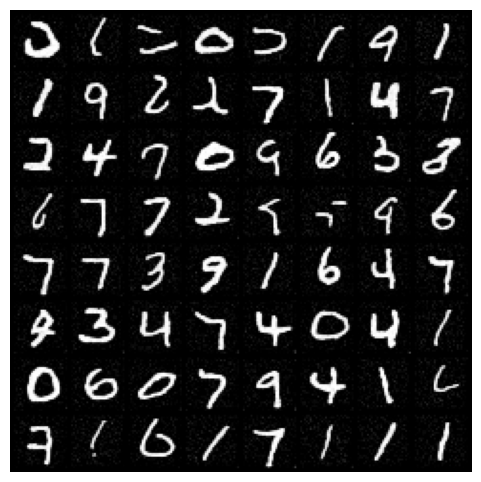

In [20]:
from torchvision.utils import make_grid
import time

device = "cuda"
ckpt = torch.load("ckpt.pth", map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = pc_sampler

t1 = time.time()
samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, sample_batch_size, device=device)
t2 = time.time()
print(f"{str(sampler)} sampling time {t2-t1}s")

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_59481/1764053612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                              | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_59481/1764053612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|███████████████████████████████████████████████████| 500/500 [00:01<00:00, 440.86it/s]


<function euler_sampler at 0x7fcf5954daf0> sampling time 1.1381261348724365s


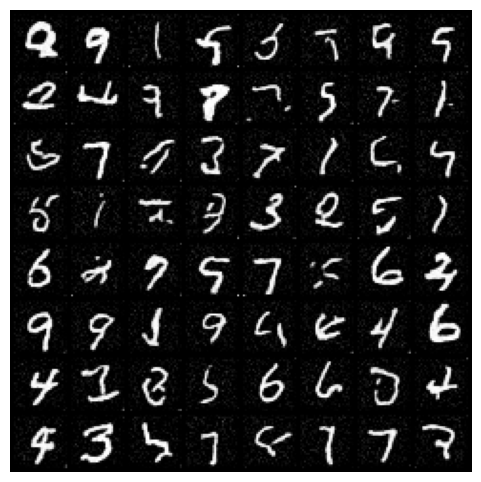

In [23]:
from torchvision.utils import make_grid
import time

device = "cuda"
ckpt = torch.load("ckpt.pth", map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = euler_sampler

t1 = time.time()
samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, sample_batch_size, device=device)
t2 = time.time()
print(f"{str(sampler)} sampling time {t2-t1}s")

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_59481/1764053612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_59481/1764053612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluation: 308
<function ode_sampler at 0x7fcf66e5e8b0> sampling time 0.9843394756317139s


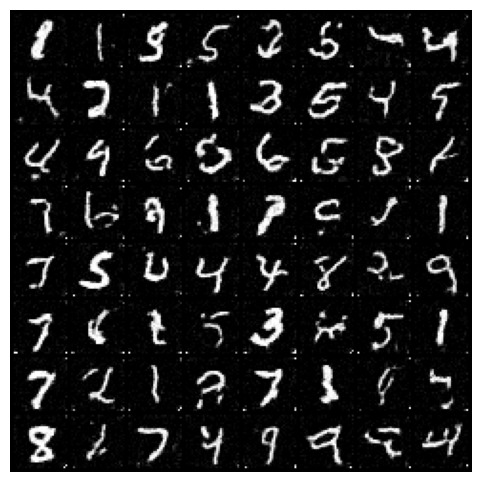

In [24]:
from torchvision.utils import make_grid
import time

device = "cuda"
ckpt = torch.load("ckpt.pth", map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = ode_sampler

t1 = time.time()
samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, sample_batch_size, device=device)
t2 = time.time()
print(f"{str(sampler)} sampling time {t2-t1}s")

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()